In [253]:
import numpy as np
import pandas as pd
import torch
import os

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split,Dataset
import torch.nn as nn
from torchsummary import summary

測試cuda是否可用

In [254]:
torch.cuda.is_available()

True

讀取training data 與 test data 、建立transform

In [255]:
train_path=r"C:/Users/MJ/Desktop/Character_Recognition/train_in.csv"
test_path=r"C:/Users/MJ/Desktop/Character_Recognition/test_in.csv"

建立Dataset class

In [256]:
class NumberDataset(Dataset):
    def __init__(self,data_path,seq_length,is_train=True):

        super().__init__()
        self.data=pd.read_csv(data_path)
        self.data=self.data.drop('Serial No.',axis=1)
        self.data=self.data.values
        self.data=torch.tensor(self.data,dtype=torch.float32)
        self.label=pd.read_csv("C:/Users/MJ/Desktop/Character_Recognition/train_out.csv")
        self.seq_length = seq_length
        self.is_train=is_train
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self,idx):
        X=self.data[idx].view(self.seq_length,2)

        if(self.is_train==True):
            label=torch.tensor(self.label['Label'].values)
            y=label[idx]
            return X,y
        else:
            return X

        

將data切成training data 和validation data，再將兩者與test data 裝成dataset

In [257]:
dataset=NumberDataset(train_path,8,is_train=True)
trainset, validset = random_split(dataset, [0.9, 0.1])
train_size=len(trainset)
valid_size=len(validset)
testset=NumberDataset(test_path,8,is_train=False)

將dataset裝進dataloader

In [258]:
train_dl=DataLoader(trainset,shuffle=True, batch_size=500)
valid_dl=DataLoader(validset,shuffle=True, batch_size=500)
test_dl=DataLoader(testset,shuffle=False, batch_size=500)

建立model class

In [259]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super().__init__()
        self.hidden_size1 = hidden_size1
       
        self.rnn = nn.RNN(input_size, hidden_size1, batch_first=True, nonlinearity='relu')
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)  # 新增的線性層
        self.relu=nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # 初始化隱藏狀態
        hidden = torch.zeros(1, batch_size, self.hidden_size1, dtype=x.dtype).to(x.device)
        out, _ = self.rnn(x, hidden)

        # 提取最後一個時間步的輸出並進行分類
        out = self.fc1(out[:, -1, :])
        out=self.relu(out)
        out = self.fc2(out)
        return out

設定訓練的參數

In [260]:
epochs=30
model=RNNClassifier(2,128,100,10)
model=model.cuda()  #將模型放到gpu上
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

train model和使用validation data評估model

In [261]:
train_losses = []
train_accu = []
val_losses=[]
val_accu = []

for epoch in range(epochs):
        model.train()
        train_loss=0
        accu=0
        ###################
        # train the model #
        ###################
        for data, target in train_dl:
                
                optim.zero_grad()
                data,target=data.cuda(),target.cuda()  #將data、target放到gpu上

                out = model(data)
                _, y_pred_tag = torch.max(out, dim = 1)  

                loss = criterion(out, target)
                loss.backward()
                
                optim.step()

                train_loss += loss.item()*data.size(0)  #loss.item is batch loss mean
                correct=torch.sum(y_pred_tag == target).item()  #sum 預測正確的次數
                accu += correct 
                

        train_loss=train_loss/train_size              # 1 epoch loss mean 
        accu=accu/train_size                          # 1 epoch accuracy mean
        train_losses.append(train_loss)
        train_accu.append(accu)


        ######################    
        # validate the model #
        ######################
        val_loss = 0
        accu = 0

        with torch.no_grad():
                model.eval()   

                for data, target in valid_dl:

                        data,target=data.cuda(),target.cuda()
                        out= model(data)
                        _, y_pred_tag = torch.max(out, dim = 1)
                        loss = criterion(out, target)

                        val_loss += loss.item()*data.size(0)
                        correct=torch.sum(y_pred_tag == target).item()
                        accu += correct      

                val_loss=val_loss/valid_size
                accu=accu/valid_size

                val_losses.append(val_loss)
                val_accu.append(accu)

                

將每個epoch的 Accuracy 和 Loss平均值畫出

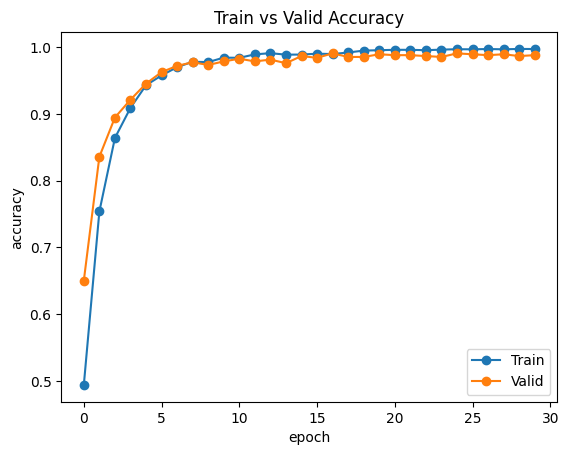

In [262]:
plt.plot(train_accu,'-o')
plt.plot(val_accu,'-o')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

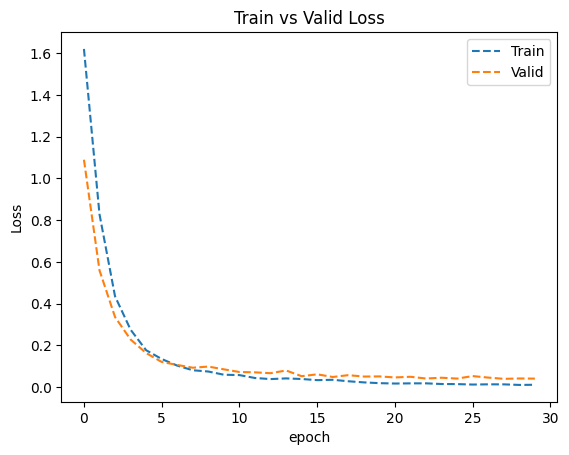

In [263]:
plt.plot(train_losses,'--')
plt.plot(val_losses,'--')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()

將test data丟進模型預測

In [264]:
model.eval()

output=[]
with torch.no_grad():
    for data in test_dl:
        data=data.cuda()
        out = model(data)
        _, y_pred_tag = torch.max(out, dim = 1)
        output.extend(y_pred_tag.cpu().numpy().tolist())


將預測結果寫成csv檔，並存起來

In [265]:
sample_submission=pd.read_csv(r"C:/Users/MJ/Desktop/Character_Recognition/sample_truth.csv")
sample_submission['Label']=output
sample_submission.to_csv(r"C:/Users/MJ/Desktop/Character_Recognition/sample_truth.csv",index=False)